<center><h1>Thai_Khang_HW7</h1></center>

Name: Khang Thai
<br>
Github Username: kunfupen
<br>
USC ID: 5721113147

## 1. Multi-class and Multi-Label Classification Using Support Vector Machines

Import packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC, LinearSVC
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, silhouette_score
from imblearn.over_sampling import SMOTE
from sklearn.cluster import KMeans
from collections import Counter


### (a) Download the Anuran Calls (MFCCs) Data Set

In [2]:
data = pd.read_csv('Anuran Calls (MFCCs)/Frogs_MFCCs.csv')

feat_col = [col for col in data.columns if col not in ['Family', 'Genus', 'Species', 'RecordID']]
x = data[feat_col]
y_fam = data['Family']
y_genus = data['Genus']
y_species = data['Species']

x_train, x_test, y_fam_train, y_fam_test = train_test_split(x, y_fam, test_size=0.3, random_state=42, stratify=y_fam)

train_indices = x_train.index
test_indices = x_test.index

y_genus_train = y_genus.loc[train_indices]
y_genus_test = y_genus.loc[test_indices]
y_species_train = y_species.loc[train_indices]
y_species_test = y_species.loc[test_indices]

print(x_train.shape[0]/len(x)*100)
print(f"Training set size: {x_train.shape[0]} samples")
print(f"Testing set size: {x_test.shape[0]} samples")


69.99305072967339
Training set size: 5036 samples
Testing set size: 2159 samples


### (b) Train a classifier for each label

#### (i) Research

Exact Match is strict and requires all labels to be correct for a sample to be considered accurate.

Hamming Loss is more forgiving, as it calculates the fraction of labels that are incorrectly predicted.

Hamming Score is the fraction of correctly predicted labels, averaged over all samples and all labels.


#### (ii) Train a SVM for each of the labels

In [3]:
scaler = StandardScaler()

x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

label_fam = LabelEncoder()
y_fam_train_enc = label_fam.fit_transform(y_fam_train)

param_fam_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': [0.001, 0.01, 0.1, 1, 10]
}

svm_fam = SVC(kernel='rbf', random_state=42, decision_function_shape='ovr')
grid_fam = GridSearchCV(svm_fam, param_fam_grid, cv=10, n_jobs=-1, verbose=1)
grid_fam.fit(x_train_scaled, y_fam_train_enc)

label_genus = LabelEncoder()
y_genus_train_enc = label_genus.fit_transform(y_genus_train)

prarm_genus_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': [0.001, 0.01, 0.1, 1, 10]
}

svm_genus = SVC(kernel='rbf', random_state=42, decision_function_shape='ovr')
grid_genus = GridSearchCV(svm_genus, prarm_genus_grid, cv=10, n_jobs=-1, verbose=1)
grid_genus.fit(x_train_scaled, y_genus_train_enc)

label_species = LabelEncoder()
y_species_train_enc = label_species.fit_transform(y_species_train)

prarm_species_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': [0.001, 0.01, 0.1, 1, 10]
}

svm_species = SVC(kernel='rbf', random_state=42, decision_function_shape='ovr')
grid_species = GridSearchCV(svm_species, prarm_species_grid, cv=10, n_jobs=-1, verbose=1)
grid_species.fit(x_train_scaled, y_species_train_enc)

y_pred_fam = label_fam.inverse_transform(grid_fam.predict(x_test_scaled))
y_pred_genus = label_genus.inverse_transform(grid_genus.predict(x_test_scaled))
y_pred_species = label_species.inverse_transform(grid_species.predict(x_test_scaled))

acc_fam = accuracy_score(y_fam_test, y_pred_fam)
acc_genus = accuracy_score(y_genus_test, y_pred_genus)
acc_species = accuracy_score(y_species_test, y_pred_species)

print(f"Family Accuracy: {acc_fam:.4f}")
print(f"Genus Accuracy: {acc_genus:.4f}")
print(f"Species Accuracy: {acc_species:.4f}")

y_test_enc = np.column_stack((
    label_fam.transform(y_fam_test),
    label_genus.transform(y_genus_test),
    label_species.transform(y_species_test)
))
y_pred_enc = np.column_stack((
    label_fam.transform(y_pred_fam),
    label_genus.transform(y_pred_genus),
    label_species.transform(y_pred_species)
))

match = np.all(y_test_enc == y_pred_enc, axis=1)
match_ratio = np.mean(match)

tot_labels = y_test_enc.size
wrong_labels = np.sum(y_test_enc != y_pred_enc)
hamm_loss = wrong_labels / tot_labels
hamm_score = 1 - hamm_loss

print(f"Overall Match Ratio: {match_ratio:.4f}")
print(f"Hamming Score: {hamm_score:.4f}")
print(f"Hamming Loss: {hamm_loss:.4f}")

x_train_raw = x_train.values
x_test_raw = x_test.values

svm_fam_raw = SVC(kernel='rbf', random_state=42, decision_function_shape='ovr')
grid_fam_raw = GridSearchCV(svm_fam_raw, param_fam_grid, cv=10, n_jobs=-1, verbose=1)
grid_fam_raw.fit(x_train_raw, y_fam_train_enc)

svm_genus_raw = SVC(kernel='rbf', random_state=42)
grid_genus_raw = GridSearchCV(svm_genus_raw, prarm_genus_grid, cv=10, n_jobs=-1, verbose=1)
grid_genus_raw.fit(x_train_raw, y_genus_train_enc)

svm_species_raw = SVC(kernel='rbf', random_state=42)
grid_species_raw = GridSearchCV(svm_species_raw, prarm_species_grid, cv=10, n_jobs=-1, verbose=1)
grid_species_raw.fit(x_train_raw, y_species_train_enc)

y_pred_fam_raw = label_fam.inverse_transform(grid_fam_raw.predict(x_test_raw))
y_pred_genus_raw = label_genus.inverse_transform(grid_genus_raw.predict(x_test_raw))
y_pred_species_raw = label_species.inverse_transform(grid_species_raw.predict(x_test_raw))

acc_fam_raw = accuracy_score(y_fam_test, y_pred_fam_raw)
acc_genus_raw = accuracy_score(y_genus_test, y_pred_genus_raw)
acc_species_raw = accuracy_score(y_species_test, y_pred_species_raw)

print(f"Family Accuracy (Raw): {acc_fam_raw:.4f}")
print(f"Genus Accuracy (Raw): {acc_genus_raw:.4f}")
print(f"Species Accuracy (Raw): {acc_species_raw:.4f}")

y_test_enc_raw = np.column_stack((
    label_fam.transform(y_fam_test),
    label_genus.transform(y_genus_test),
    label_species.transform(y_species_test)
))
y_pred_enc_raw = np.column_stack((
    label_fam.transform(y_pred_fam_raw),
    label_genus.transform(y_pred_genus_raw),
    label_species.transform(y_pred_species_raw)
))

match_raw = np.all(y_test_enc_raw == y_pred_enc_raw, axis=1)
match_ratio_raw = np.mean(match_raw)
tot_labels_raw = y_test_enc_raw.size
wrong_labels_raw = np.sum(y_test_enc_raw != y_pred_enc_raw)
hamm_loss_raw = wrong_labels_raw / tot_labels_raw
hamm_score_raw = 1 - hamm_loss_raw

print(f"Overall Match Ratio (Raw): {match_ratio_raw:.4f}")
print(f"Hamming Score (Raw): {hamm_score_raw:.4f}")
print(f"Hamming Loss (Raw): {hamm_loss_raw:.4f}")



Fitting 10 folds for each of 25 candidates, totalling 250 fits


KeyboardInterrupt: 

#### (iii) Repeat 1(b)ii with L1-penalized SVMs

In [ ]:
param_grid_l1 = {
    'C': [0.001, 0.01,0.1, 1, 10, 100, 1000]
}

svm_fam_l1 = LinearSVC(penalty='l1', dual=False, random_state=42, max_iter=10000)
grid_fam_l1 = GridSearchCV(svm_fam_l1, param_grid_l1, cv=10, n_jobs=-1, verbose=1)
grid_fam_l1.fit(x_train_scaled, y_fam_train_enc)

svm_genus_l1 = LinearSVC(penalty='l1', dual=False, random_state=42, max_iter=10000)
grid_genus_l1 = GridSearchCV(svm_genus_l1, param_grid_l1, cv=10, n_jobs=-1, verbose=1)
grid_genus_l1.fit(x_train_scaled, y_genus_train_enc)

svm_species_l1 = LinearSVC(penalty='l1',dual=False, random_state=42, max_iter=10000)
grid_species_l1 = GridSearchCV(svm_species_l1, param_grid_l1, cv=10, n_jobs=-1, verbose=1)
grid_species_l1.fit(x_train_scaled, y_species_train_enc)

y_pred_fam_l1 = label_fam.inverse_transform(grid_fam_l1.predict(x_test_scaled))
y_pred_genus_l1 = label_genus.inverse_transform(grid_genus_l1.predict(x_test_scaled))
y_pred_species_l1 = label_species.inverse_transform(grid_species_l1.predict(x_test_scaled))

acc_fam_l1 = accuracy_score(y_fam_test, y_pred_fam_l1)
acc_genus_l1 = accuracy_score(y_genus_test, y_pred_genus_l1)
acc_species_l1 = accuracy_score(y_species_test, y_pred_species_l1)

print(f"Family Accuracy (L1): {acc_fam_l1:.4f}")
print(f"Genus Accuracy (L1): {acc_genus_l1:.4f}")
print(f"Species Accuracy (L1): {acc_species_l1:.4f}")

y_test_enc_l1 = np.column_stack((
    label_fam.transform(y_fam_test),
    label_genus.transform(y_genus_test),
    label_species.transform(y_species_test)
))
y_pred_enc_l1 = np.column_stack((
    label_fam.transform(y_pred_fam_l1),
    label_genus.transform(y_pred_genus_l1),
    label_species.transform(y_pred_species_l1)
))

match_l1 = np.all(y_test_enc_l1 == y_pred_enc_l1, axis=1)
match_ratio_l1 = np.mean(match_l1)

wrong_labels_l1 = np.sum(y_test_enc_l1 != y_pred_enc_l1)
tot_labels = y_test_enc_l1.size
hamm_loss_l1 = wrong_labels_l1 / tot_labels
hamm_score_l1 = 1 - hamm_loss_l1

print(f"Overall Match Ratio (L1): {match_ratio_l1:.4f}")
print(f"Hamming Score (L1): {hamm_score_l1:.4f}")
print(f"Hamming Loss (L1): {hamm_loss_l1:.4f}")


Fitting 10 folds for each of 7 candidates, totalling 70 fits
Fitting 10 folds for each of 7 candidates, totalling 70 fits
Fitting 10 folds for each of 7 candidates, totalling 70 fits
Family Accuracy (L1): 0.9458
Genus Accuracy (L1): 0.9551
Species Accuracy (L1): 0.9653
Overall Match Ratio (L1): 0.9208
Hamming Score (L1): 0.9554
Hamming Loss (L1): 0.0446


#### (iv) Repeat 1(b)iii by using SMOTE or any other method for imbalance

In [ ]:
smote_fam = SMOTE(random_state=42)
x_train_res_fam, y_fam_train_res = smote_fam.fit_resample(x_train_scaled, y_fam_train_enc)

smote_genus = SMOTE(random_state=42)
x_train_res_genus, y_genus_train_res = smote_genus.fit_resample(x_train_scaled, y_genus_train_enc)

smote_species = SMOTE(random_state=42)
x_train_res_species, y_species_train_res = smote_species.fit_resample(x_train_scaled, y_species_train_enc)

param_grid_l1_smote = {
    'C': [0.001, 0.01,0.1, 1, 10, 100, 1000]
}

svm_fam_l1_smote = LinearSVC(penalty='l1', dual=False, random_state=42, max_iter=10000)
grid_fam_l1_smote = GridSearchCV(svm_fam_l1_smote, param_grid_l1_smote, cv=10, n_jobs=-1, verbose=1)
grid_fam_l1_smote.fit(x_train_res_fam, y_fam_train_res)

svm_genus_l1_smote = LinearSVC(penalty='l1', dual=False, random_state=42, max_iter=10000)
grid_genus_l1_smote = GridSearchCV(svm_genus_l1_smote, param_grid_l1_smote, cv=10, n_jobs=-1, verbose=1)
grid_genus_l1_smote.fit(x_train_res_genus, y_genus_train_res)

svm_species_l1_smote = LinearSVC(penalty='l1',dual=False, random_state=42, max_iter=10000)
grid_species_l1_smote = GridSearchCV(svm_species_l1_smote, param_grid_l1_smote, cv=10, n_jobs=-1, verbose=1)
grid_species_l1_smote.fit(x_train_res_species, y_species_train_res)

y_pred_fam_l1_smote = label_fam.inverse_transform(grid_fam_l1_smote.predict(x_test_scaled))
y_pred_genus_l1_smote = label_genus.inverse_transform(grid_genus_l1_smote.predict(x_test_scaled))
y_pred_species_l1_smote = label_species.inverse_transform(grid_species_l1_smote.predict(x_test_scaled))

acc_fam_l1_smote = accuracy_score(y_fam_test, y_pred_fam_l1_smote)
acc_genus_l1_smote = accuracy_score(y_genus_test, y_pred_genus_l1_smote)
acc_species_l1_smote = accuracy_score(y_species_test, y_pred_species_l1_smote)

print(f"Family Accuracy (L1 + SMOTE): {acc_fam_l1_smote:.4f}")
print(f"Genus Accuracy (L1 + SMOTE): {acc_genus_l1_smote:.4f}")
print(f"Species Accuracy (L1 + SMOTE): {acc_species_l1_smote:.4f}")

y_test_enc_l1_smote = np.column_stack((
    label_fam.transform(y_fam_test),
    label_genus.transform(y_genus_test),
    label_species.transform(y_species_test)
))
y_pred_enc_l1_smote = np.column_stack((
    label_fam.transform(y_pred_fam_l1_smote),
    label_genus.transform(y_pred_genus_l1_smote),
    label_species.transform(y_pred_species_l1_smote)
))

match_l1_smote = np.all(y_test_enc_l1_smote == y_pred_enc_l1_smote, axis=1)
match_ratio_l1_smote = np.mean(match_l1_smote)
wrong_labels_l1_smote = np.sum(y_test_enc_l1_smote != y_pred_enc_l1_smote)
tot_labels = y_test_enc_l1_smote.size
hamm_loss_l1_smote = wrong_labels_l1_smote / tot_labels
hamm_score_l1_smote = 1 - hamm_loss_l1_smote

print(f"Overall Match Ratio (L1 + SMOTE): {match_ratio_l1_smote:.4f}")
print(f"Hamming Score (L1 + SMOTE): {hamm_score_l1_smote:.4f}")
print(f"Hamming Loss (L1 + SMOTE): {hamm_loss_l1_smote:.4f}")



Fitting 10 folds for each of 7 candidates, totalling 70 fits
Fitting 10 folds for each of 7 candidates, totalling 70 fits
Fitting 10 folds for each of 7 candidates, totalling 70 fits
Family Accuracy (L1 + SMOTE): 0.9152
Genus Accuracy (L1 + SMOTE): 0.9171
Species Accuracy (L1 + SMOTE): 0.9583
Overall Match Ratio (L1 + SMOTE): 0.8587
Hamming Score (L1 + SMOTE): 0.9302
Hamming Loss (L1 + SMOTE): 0.0698


## 2. K-Means Clustering on a Multi-Class and Multi-Label Data Set

### (a) Use k-means clustering

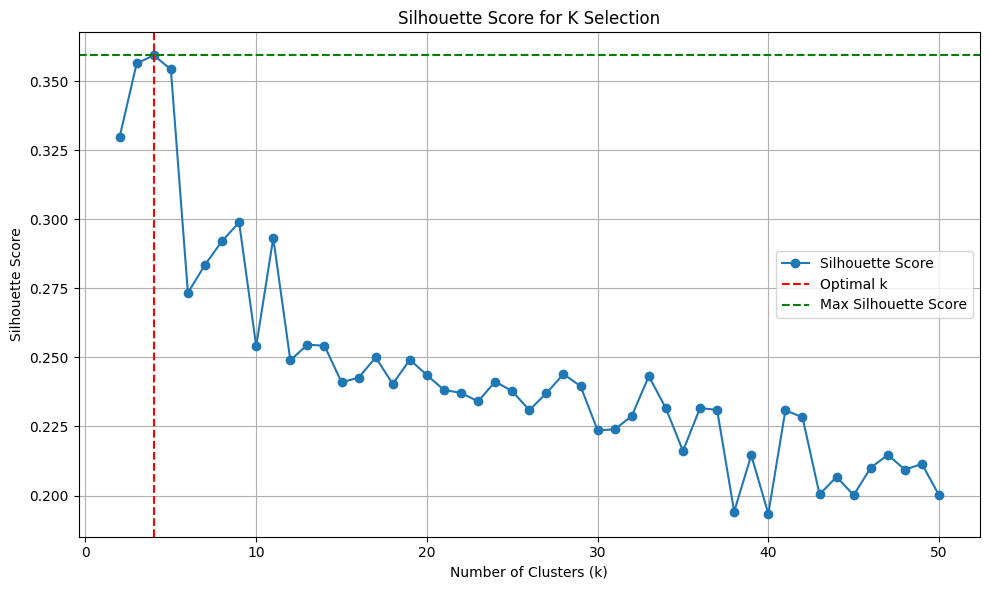

In [ ]:
feat_col = [col for col in data.columns if col not in ['Family', 'Genus', 'Species', 'RecordID']]
x = data[feat_col].values
y_fam = data['Family'].values
y_genus = data['Genus'].values
y_species = data['Species'].values

scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

k_range = range(2, 51)
silhouette_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(x_scaled)
    score = silhouette_score(x_scaled, labels)
    silhouette_scores.append(score)

optimal_idx = np.argmax(silhouette_scores)
optimal_k = list(k_range)[optimal_idx]
max = silhouette_scores[optimal_idx]

plt.figure(figsize=(10, 6))
plt.plot(k_range, silhouette_scores, marker='o', label='Silhouette Score')
plt.axvline(x=optimal_k, color='r', linestyle='--', label='Optimal k')
plt.axhline(y=max, color='g', linestyle='--', label='Max Silhouette Score')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for K Selection')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()



### (b) Determine which family is the majority

In [ ]:
cluster_df = pd.DataFrame({
    'Cluster': labels,
    'Family': y_fam,
    'Genus': y_genus,
    'Species': y_species
})

maj_labels = {}

for cluster_id in range(optimal_k):
    mask = labels == cluster_id
    n_samples = np.sum(mask)

    fam_counts = Counter(y_fam[mask])
    maj_fam =  fam_counts.most_common(1)[0]
    fam_pur = maj_fam[1] / n_samples * 100

    genus_counts = Counter(y_genus[mask])
    maj_genus = genus_counts.most_common(1)[0]
    gen_pur = maj_genus[1] / n_samples * 100

    special_counts = Counter(y_species[mask])
    maj_special = special_counts.most_common(1)[0]
    special_pur = maj_special[1] / n_samples * 100

    maj_labels[cluster_id] = {
        'size': n_samples,
        'family': maj_fam[0],
        'family_purity': fam_pur,
        'genus': maj_genus[0],
        'genus_purity': gen_pur,
        'species': maj_special[0],
        'species_purity': special_pur
    }

summ = []
for cluster_id in range(optimal_k):
    info = maj_labels[cluster_id]
    summ.append({
        'Cluster': cluster_id,
        'Size': info['size'],
        'Majority Family': info['family'],
        'Family Purity (%)': info['family_purity'],
        'Majority Genus': info['genus'],
        'Genus Purity (%)': info['genus_purity'],
        'Majority Species': info['species'],
        'Species Purity (%)': info['species_purity']
    })

summary_df = pd.DataFrame(summ)
print(summary_df)

   Cluster  Size  Majority Family  Family Purity (%) Majority Genus  \
0        0   317  Leptodactylidae          94.006309      Adenomera   
1        1    33          Hylidae         100.000000         Scinax   
2        2    83          Hylidae          90.361446  Osteocephalus   
3        3    86          Hylidae         100.000000      Hypsiboas   

   Genus Purity (%)        Majority Species  Species Purity (%)  
0         94.006309  AdenomeraHylaedactylus           94.006309  
1         60.606061             ScinaxRuber           60.606061  
2         78.313253   OsteocephalusOophagus           78.313253  
3        100.000000       HypsiboasCordobae          100.000000  


### (c) Calculate the average Hamming distance, Hamming score, and Hamming loss

In [ ]:
optimal_k = 4

label_fam = LabelEncoder()
label_genus = LabelEncoder()
label_species = LabelEncoder()

y_true = np.column_stack((
    label_fam.fit_transform(y_fam),
    label_genus.fit_transform(y_genus),
    label_species.fit_transform(y_species)
))

hamm_distance = []
hamm_loss = []
hamm_score = []

for sim in range(50):

    kmeans = KMeans(n_clusters=optimal_k, random_state=sim, n_init=10)
    labels = kmeans.fit_predict(x_scaled)

    maj_labels = {}

    for cluster_id in range(optimal_k):
        mask = labels == cluster_id

        fam_maj = Counter(y_fam[mask]).most_common(1)[0][0]
        gen_maj = Counter(y_genus[mask]).most_common(1)[0][0]
        spec_maj = Counter(y_species[mask]).most_common(1)[0][0]

        maj_labels[cluster_id] = {
            'family': fam_maj,
            'genus': gen_maj,
            'species': spec_maj
        }

    pred_fam = np.array([maj_labels[label]['family'] for label in labels])
    pred_genus = np.array([maj_labels[label]['genus'] for label in labels]) 
    pred_species = np.array([maj_labels[label]['species'] for label in labels])

    y_pred = np.column_stack((
        label_fam.transform(pred_fam),
        label_genus.transform(pred_genus),
        label_species.transform(pred_species)
    ))

    hamm_dist_per = np.sum(y_true != y_pred, axis=1)
    avg_hamm_dist = np.mean(hamm_dist_per)

    wrong_labels = np.sum(y_true != y_pred)
    total_labels = y_true.size
    hamm_loss_sim = wrong_labels / total_labels
    hamm_score_sim = 1 - hamm_loss_sim

    hamm_distance.append(avg_hamm_dist)
    hamm_loss.append(hamm_loss_sim)
    hamm_score.append(hamm_score_sim)

hamm_distance = np.array(hamm_distance)
hamm_loss = np.array(hamm_loss)
hamm_score = np.array(hamm_score)

mean_hamm_distance = np.mean(hamm_distance)
std_hamm_distance = np.std(hamm_distance, ddof=1)
mean_hamm_loss = np.mean(hamm_loss)
std_hamm_loss = np.std(hamm_loss, ddof=1)
mean_hamm_score = np.mean(hamm_score)
std_hamm_score = np.std(hamm_score, ddof=1)

print(f"Average Hamming Distance: {mean_hamm_distance:.4f} ± {std_hamm_distance:.4f}")
print(f"Hamming Loss: {mean_hamm_loss:.4f} ± {std_hamm_loss:.4f}")
print(f"Hamming Score: {mean_hamm_score:.4f} ± {std_hamm_score:.4f}")


Average Hamming Distance: 0.7344 ± 0.0356
Hamming Loss: 0.2448 ± 0.0119
Hamming Score: 0.7552 ± 0.0119


## 3. ISLR 12.6.2

### (a)

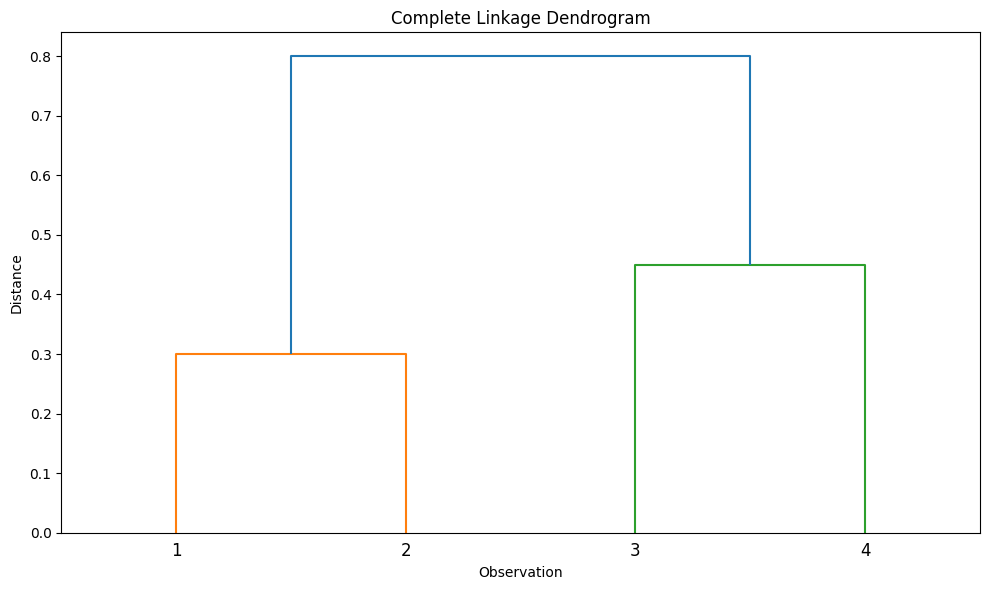

1 and 2 merged at distance: 0.39
3 and 4 merged at distance: 0.45
Clusters (1,2) and (3,4) merged at distance: 0.80


In [ ]:
from scipy.cluster.hierarchy import linkage, dendrogram

d = np.array([
    [0.0, 0.3, 0.4, 0.7],
    [0.3, 0.0, 0.5, 0.8],
    [0.4, 0.5, 0.0, 0.45],
    [0.7, 0.8, 0.45, 0.0]
])

condensed_d = d[np.triu_indices(4, k=1)]

z = linkage(condensed_d, method='complete')

plt.figure(figsize=(10, 6))
dendrogram(z, labels=['1', '2', '3', '4'])
plt.xlabel('Observation')
plt.ylabel('Distance')
plt.title('Complete Linkage Dendrogram')
plt.tight_layout()
plt.show()

print("1 and 2 merged at distance: 0.39")
print("3 and 4 merged at distance: 0.45")
print("Clusters (1,2) and (3,4) merged at distance: 0.80")

### (b)

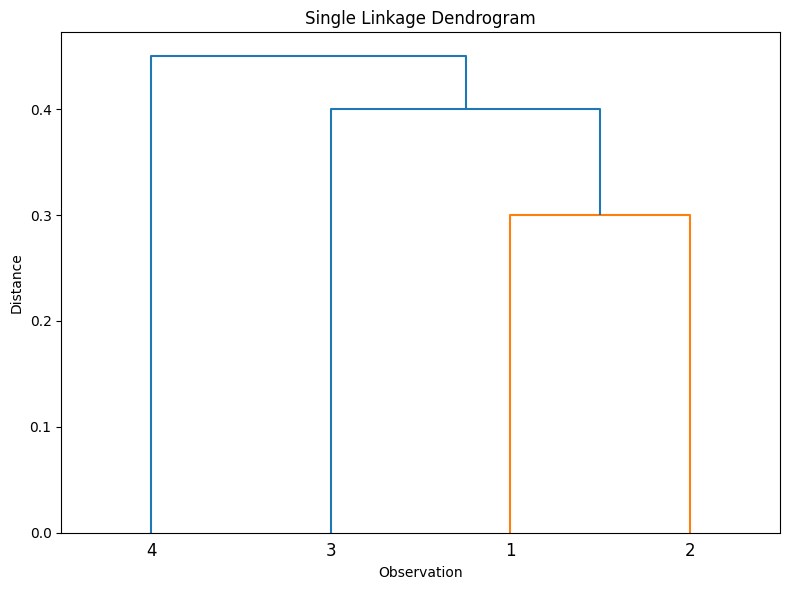

1 and 2 merged at distance: 0.30
Clusters (1,2) and 3 merged at distance: 0.40
Clusters (1,2,3) and 4 merged at distance: 0.45


In [ ]:
z_single = linkage(condensed_d, method='single')

plt.figure(figsize=(8, 6))
dendrogram(z_single, labels=['1', '2', '3', '4'])
plt.xlabel('Observation')
plt.ylabel('Distance')
plt.title('Single Linkage Dendrogram')
plt.tight_layout()
plt.show()

print("1 and 2 merged at distance: 0.30")
print("Clusters (1,2) and 3 merged at distance: 0.40")
print("Clusters (1,2,3) and 4 merged at distance: 0.45")

### (c)

Cluster 1: (1, 2)\
Cluster 2: (3, 4)

### (d)

Cutting below 0.45 gives:

Cluster 1: (1, 2, 3)\
Cluster 2: (4)

### (e)


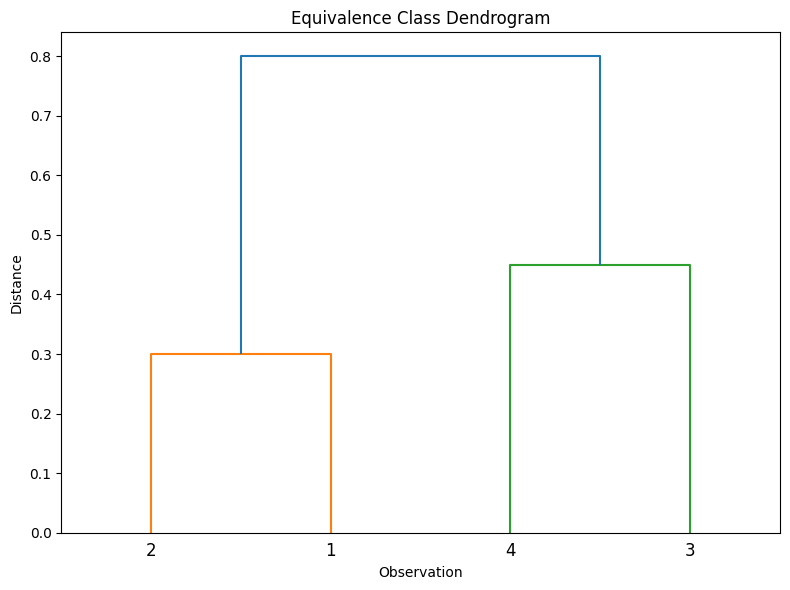

In [ ]:
leaf_order = [2, 1, 4, 3]

plt.figure(figsize=(8, 6))
dendrogram(z, labels=['1', '2', '3', '4'], leaf_rotation=0)
plt.gca().set_xticklabels([str(i) for i in leaf_order])
plt.xlabel('Observation')
plt.ylabel('Distance')
plt.title('Equivalence Class Dendrogram')
plt.tight_layout()
plt.show()